In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) == 3
# to allow other tensorflow processes to use the gpu
# https://stackoverflow.com/a/60699372/7989988
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten
import tensorflow_probability as tfp
from dotmap import DotMap

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [2]:
import models
import training
import datasets
import vizualization
import schedules

# todo
# - combine shuffled and unshuffled datasets into same thing
# - add extra shuffled indices and noise
# - add "noise fraction" parameter which can be changed the same way as the "n" parameter.
# - add different amounts of noise to the data and see what happens

In [3]:
config = DotMap({
    'ds': 'mnist',
    'distributed': True,
    'minibatch_size': 8,
    'n_steps': 120001,
    'test_size': 300,
    'test_minibatch_size': 25,
    'test_interval': 500,
    'test_n_shuf': [392, 1, 64, 128, 256],
    'test_n_seq': [392, 1, 128, 256, 512],
    'test_autoregressive': False,
    'noise_fraction': 0,
    'display_images': True,
    'display_image_interval': 500,
    'dont_display_until_loss': 0.48,
    'bg_color': [1.0, 0.4, 0.6],
    'lr_schedule': ['constant', 0.0004],
    'lr_warmup': 100,
    'grad_accum_steps': None, #['exponential', 1, 4],
    'max_accum_steps': 4,
    'use_wandb': True,
    'wandb_log_interval': 10,
    'loss_window_size': 80,
    'kmeans_batch_size': 8,
    'mixed_float': False,
})

# need to change for multiworkerstrategy
if config.distributed:
    config.num_devices = len(physical_devices)
else:
    config.num_devices = 1
config.global_batch_size = config.minibatch_size * config.num_devices

Example integers sampled from gamma distribution.
tf.Tensor(
[258 354 131  80 434  78  26 155 211  26 295 167  18  96 439 221  19 311
  93   3  74   3  13  36 506  42 156 657 240  16 118 133  21 589 213  58
 450 101 207  39 127  62 428 351 385 506  25 421 201 462  73 163 151 446
 281 569 159 184  56  12  42  79 252 112  28 119 145 389  57 294 142  47
  91 668 121 149  33 783 112 531 145  43 348 408 114 722 230  71 116 603
  37 116  11  79  57 180  76 195  25  15], shape=(100,), dtype=int32)
Dataset mnist downloaded and prepared to /local/scratch/maxeonyx/datasets/mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/local/scratch/maxeonyx/datasets/mnist/3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28

Not using gradient accumulation


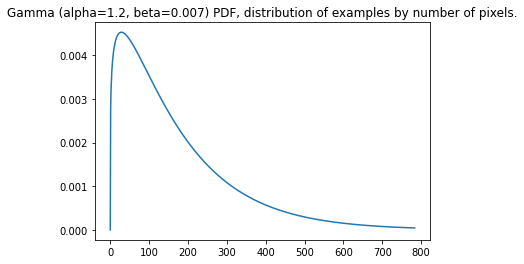

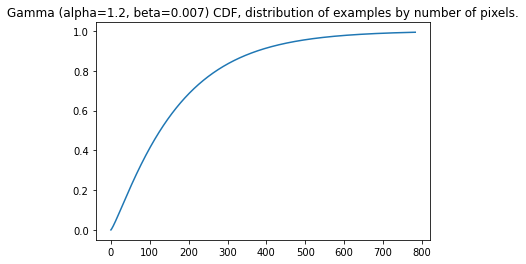

In [4]:
# idea is to not have to re-run this cell for subsequent training runs unless the centroids change

ds_configs = DotMap({
    'mnist': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'image_size': (28, 28),
    },
    'mnist_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'mnist_binary_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 2,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'cifar': {
        'name': 'cifar10',
        'buffer_size': 10000,
        'n_colors': 64,
        'n_color_dims': 3,
        'image_size': (32, 32),
    },
    'celeb': {
        'name': 'celeb_a_hq',
        'buffer_size': 10000,
        'n_colors': 16,
        'n_color_dims': 3,
        'image_size': (32, 32),
    }
})

config.dataset = ds_configs[config.ds]
config.dataset.seq_length = config.dataset.image_size[0]*config.dataset.image_size[1]*config.dataset.n_color_dims
gamma_dist, gamma_name = datasets.mnist_gamma_distribution()
datasets.plot_distribution(config, gamma_dist, gamma_name)

tfds.disable_progress_bar()
dataset, metadata = tfds.load(config.dataset.name, with_info=True, as_supervised=True, data_dir="/local/scratch/maxeonyx/datasets")

print(metadata)

ds_train_original = dataset['train']
ds_test_original = dataset['test']

# centroids = datasets.find_centroids(config, ds_train_original)
centroids = tf.random.uniform([config.dataset.n_colors, config.dataset.n_color_dims], minval=0., maxval=1.)

ds = datasets.Datasets(config, ds_train_original, ds_test_original, centroids, gamma_dist)
viz = vizualization.Viz(config, ds, centroids)
ds_train, ds_test = ds.make_datasets()


unquantized:


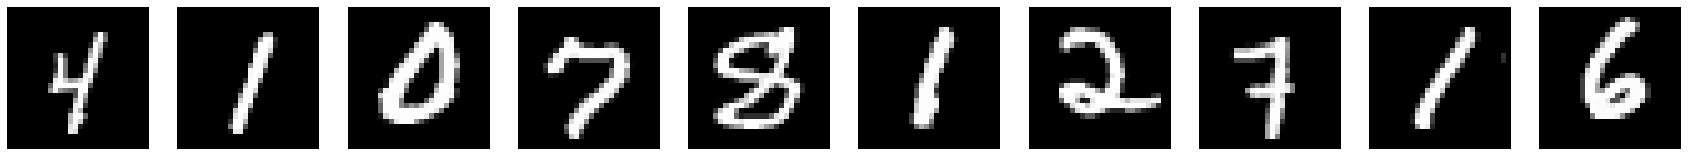

quantized:


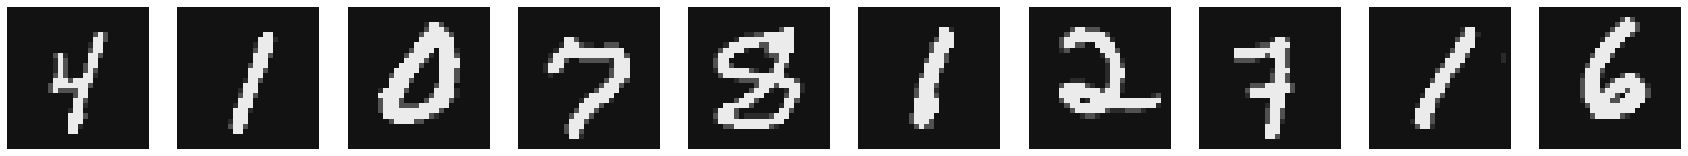

In [5]:
viz.compare_quantized_and_unquantized(ds_train_original)

# display_colors, display_idxs, *_ = next(iter(ds_train))
# if config.grad_accum_steps:
#     display_colors,display_idxs = display_colors[0],display_idxs[0]
# viz.showSeq(display_colors, display_idxs, config.dataset.image_size, max_images=9)

In [15]:


# model config
config.model = DotMap({
    'n_colors': config.dataset.n_colors,
    'n_color_dims': config.dataset.n_color_dims,
    'image_size': config.dataset.image_size,
    'seq_len': config.dataset.image_size[0] * config.dataset.image_size[1],
    'n_enc_a_layers': 6,
    'n_enc_b_layers': 3,
    'ffl_dim': 1024,
    'embd_dim': 512,
    'n_dec_layers': 2,
    'dec_dim': 400,
    'n_heads': 8,
    'dropout_rate': 0.1,
    'use_idxs_input': True,
    'architecture': 'deberta_anp',
    'position_embedding': 'pos_enc',
    'activation': 'swish',
})

if config.mixed_float:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

if config.distributed == False:
    strategy = tf.distribute.get_strategy()
else:
    strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = models.transformer(config.model)
    # Adam params taken from the linked notebook
    optimizer = keras.optimizers.Adam(learning_rate=schedules.learning_rate_schedule(config))
    if config.mixed_float:
        optimizer = keras.mixed_precision.LossScaleOptimizer(optimizer)

ds_train_dist = strategy.experimental_distribute_dataset(ds_train)

config.training_mode = 'full_combination'

import socket
model_name = models.model_name(config)
print(model_name)

# from pprint import pprint
# pprint([[x.dtype, x.name] for x in model.trainable_weights])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


cuda11-28x28-bs3x1x8


In [16]:
evaler = training.Evaluator(config, model, optimizer, viz, ds, ds_train_dist, ds_test)

training_loop = training.TrainingLoop(config, evaler, model_name)

wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Step 108, Loss (last minibatch): 0.41692766547203064, Loss (80 step avg.): 0.4755506526540827


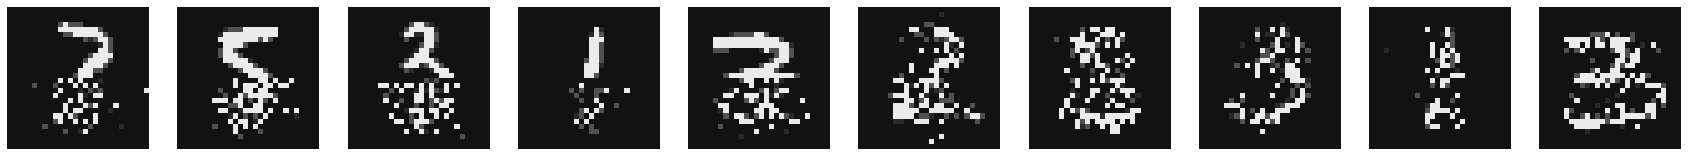

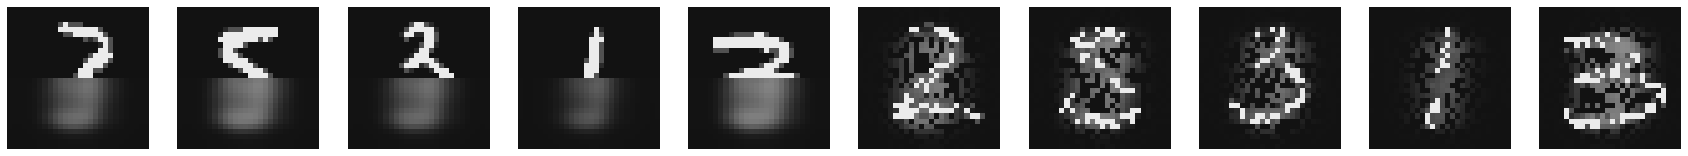

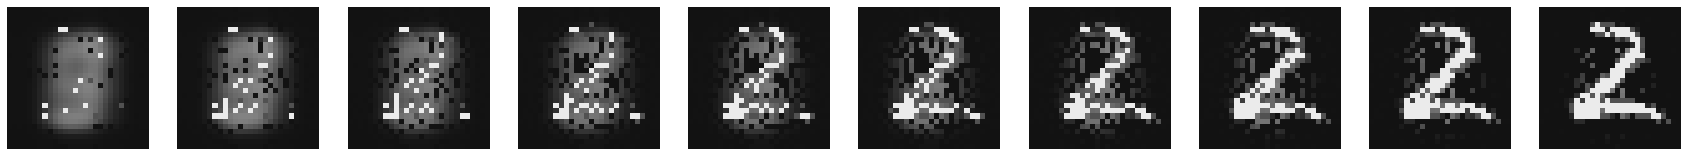

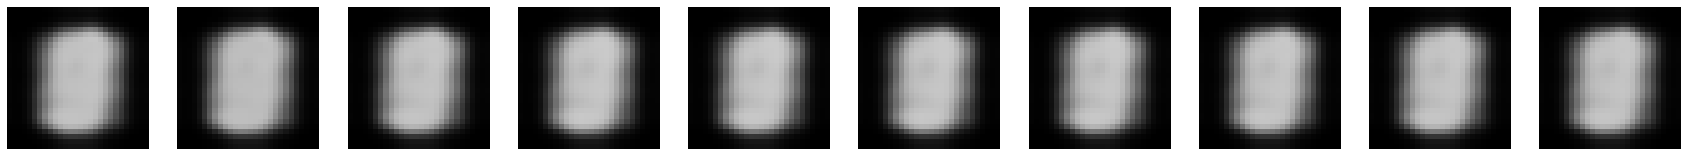

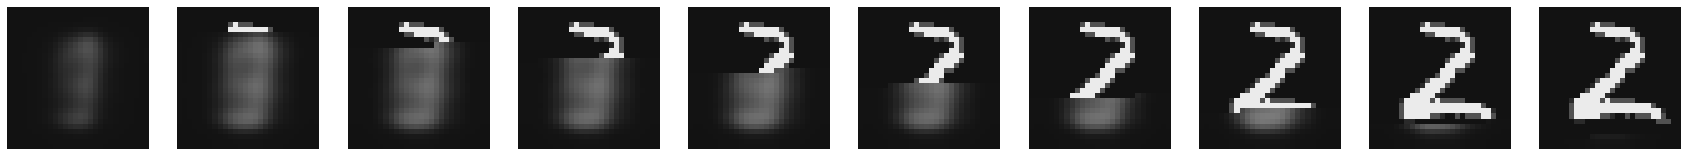

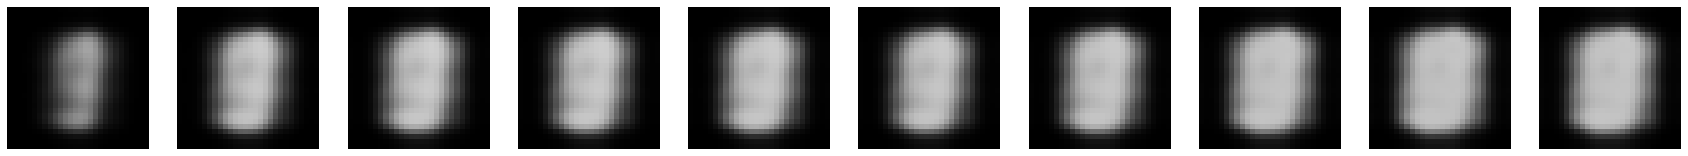

Step 148, Loss (last minibatch): 0.4140908718109131, Loss (80 step avg.): 0.42772519367712514


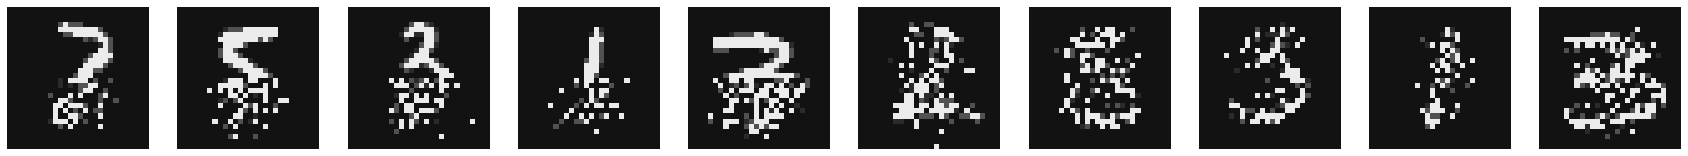

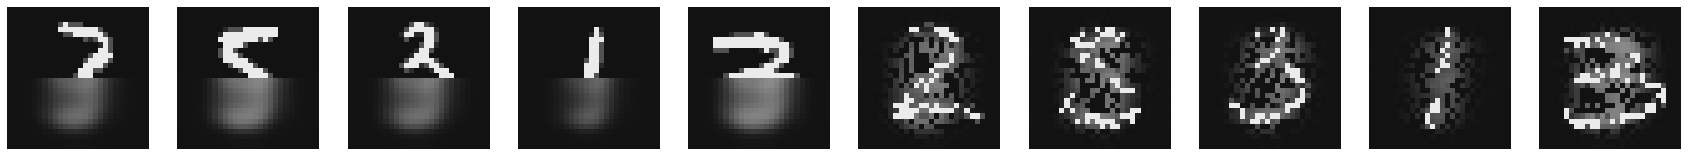

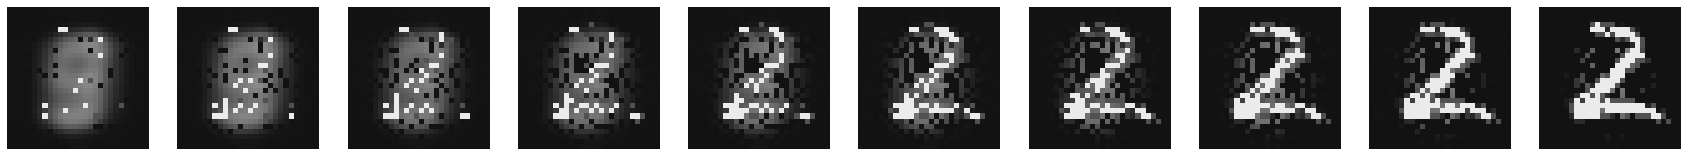

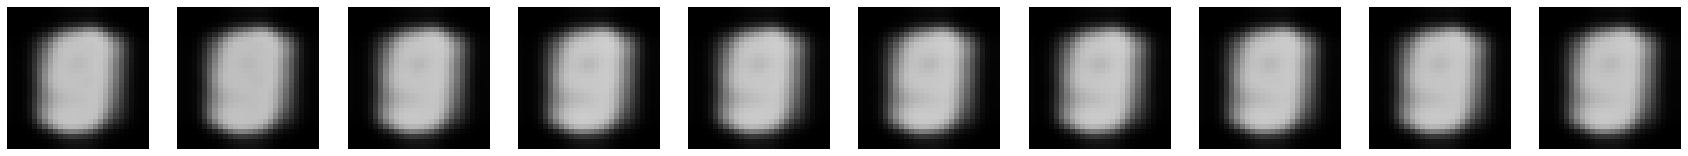

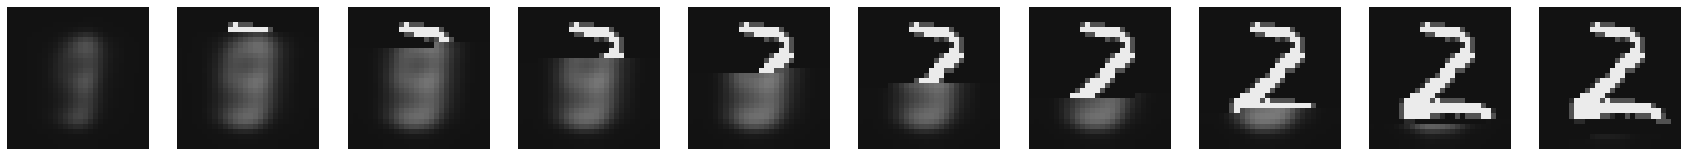

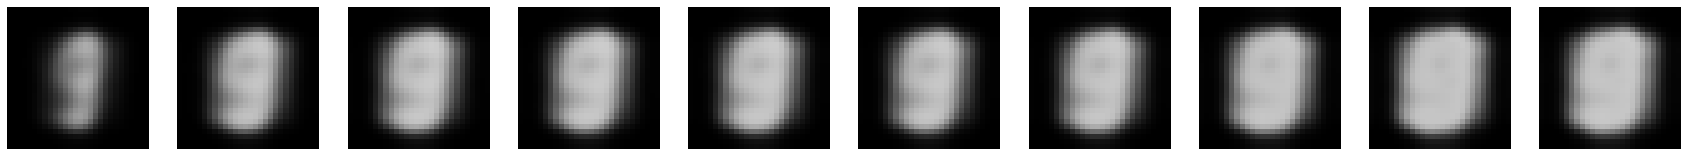

Step 534, Loss (last minibatch): 0.2538396418094635, Loss (80 step avg.): 0.3834456875000471


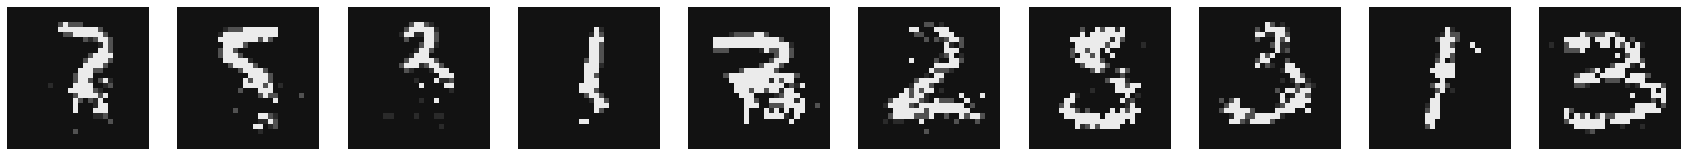

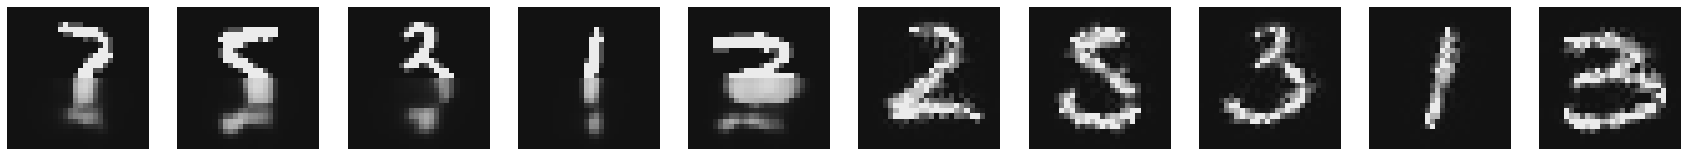

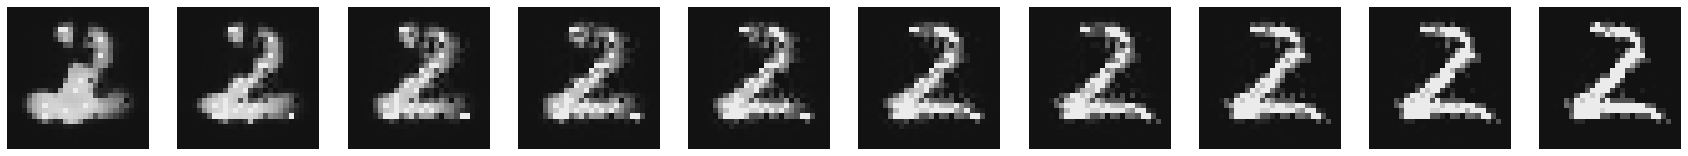

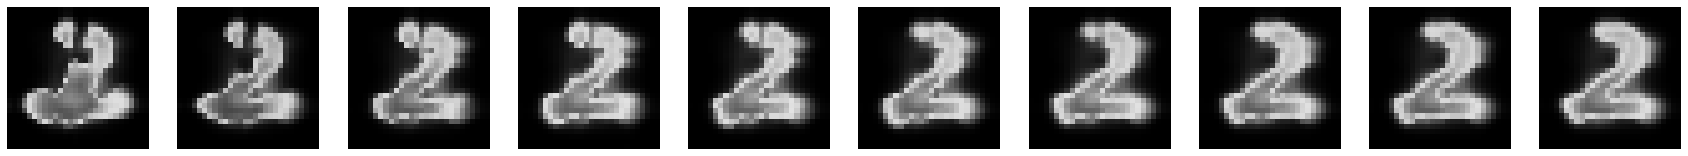

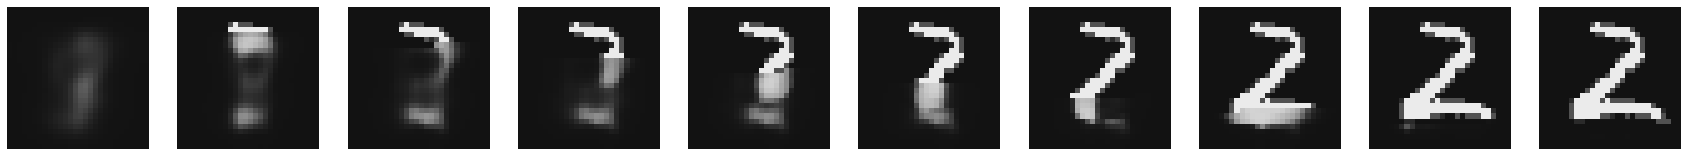

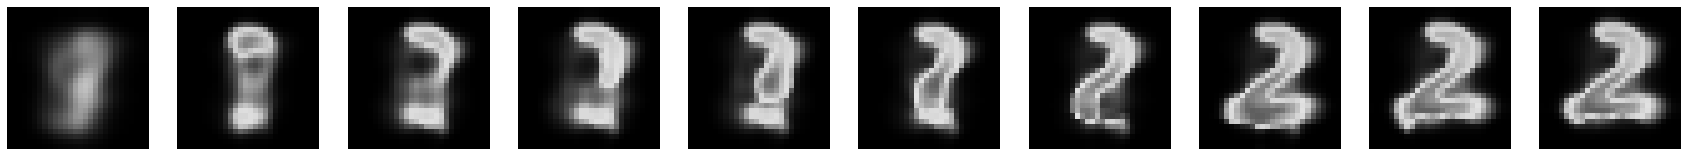

Step 570, Loss (last minibatch): 0.2701808214187622, Loss (80 step avg.): 0.34506015810701585


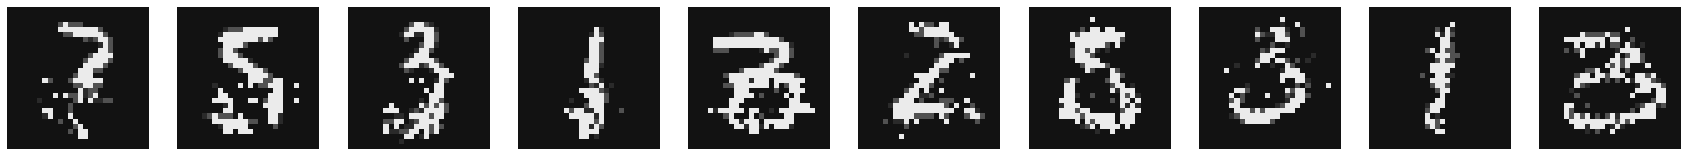

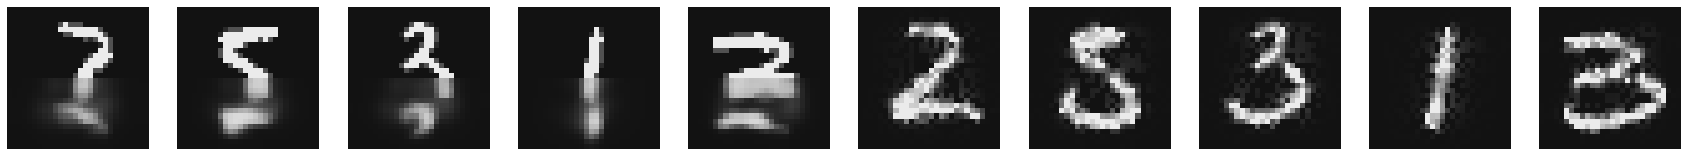

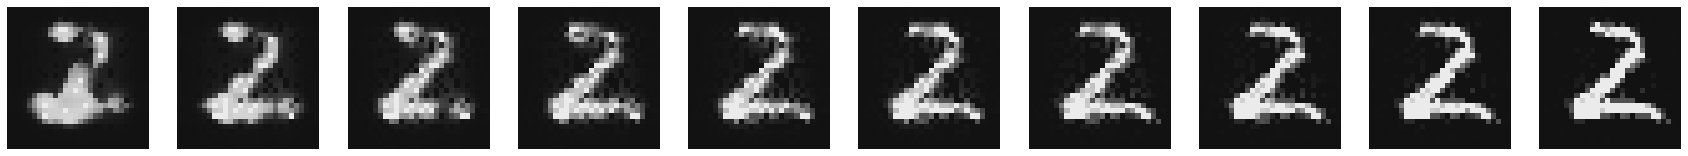

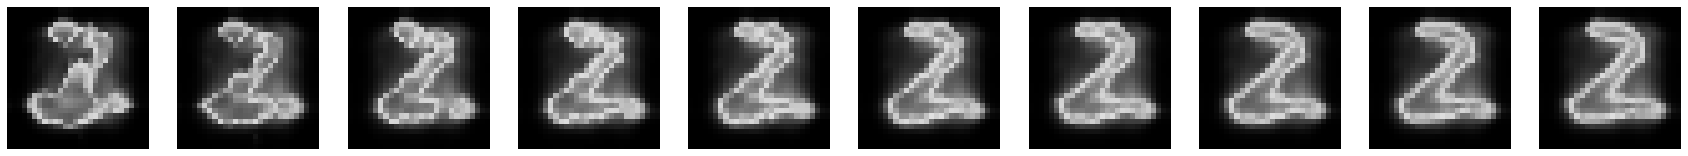

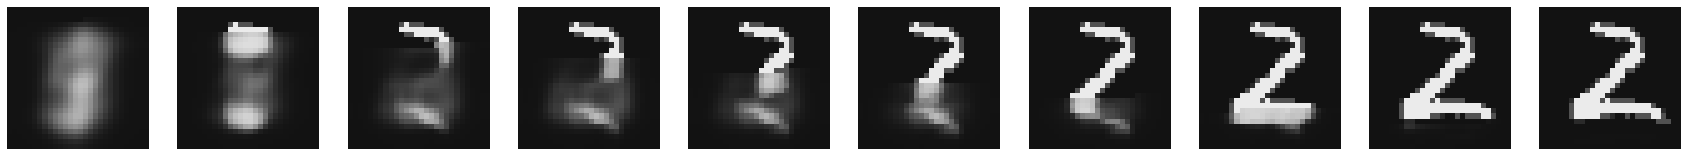

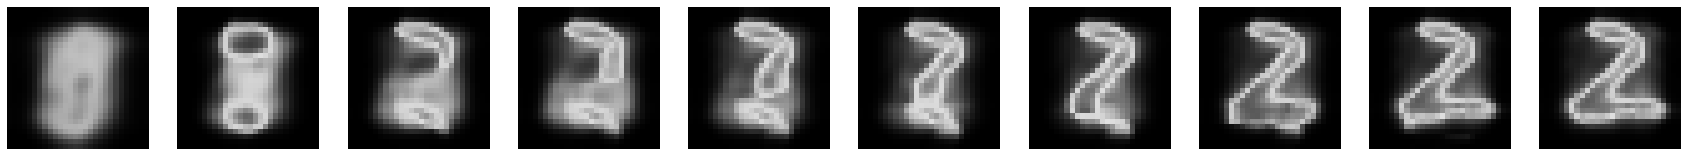

Step 600, Loss (last minibatch): 0.25628745555877686, Loss (80 step avg.): 0.30724565500830425


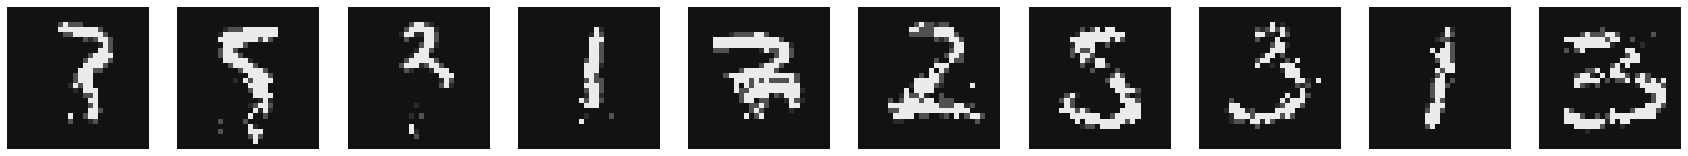

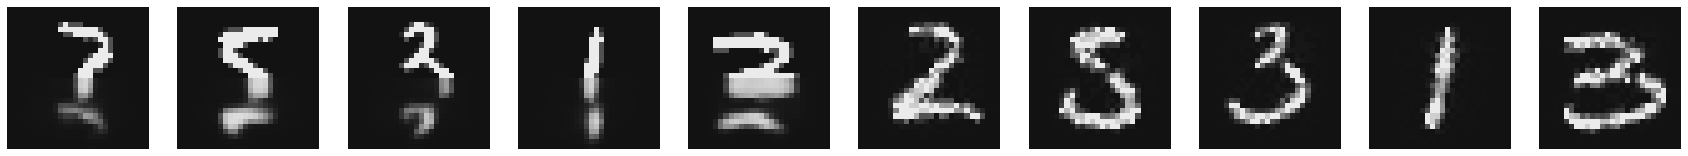

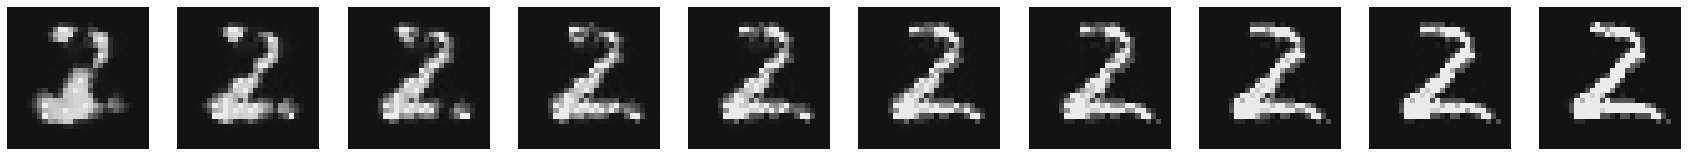

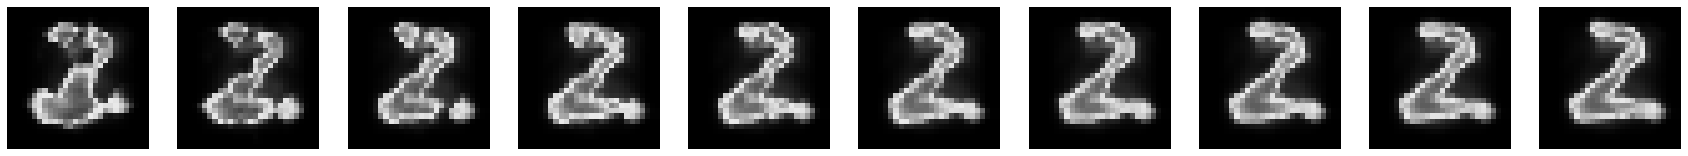

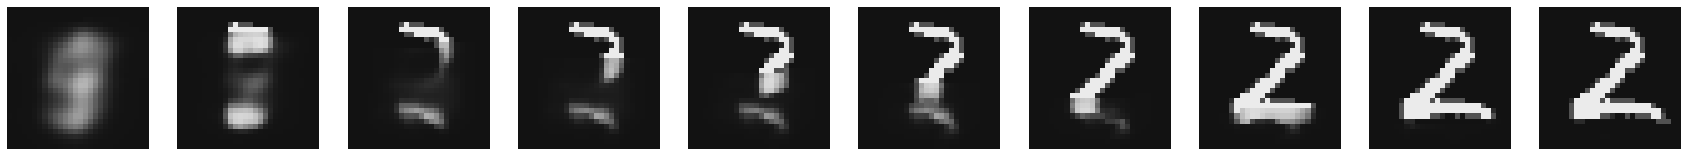

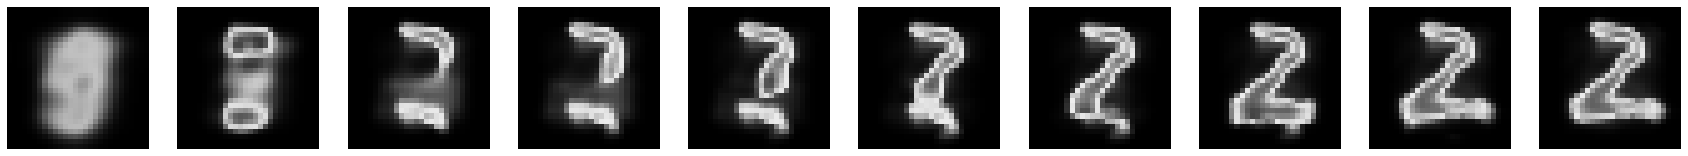

Step 665, Loss (last minibatch): 0.23627357184886932, Loss (80 step avg.): 0.27644030069127495


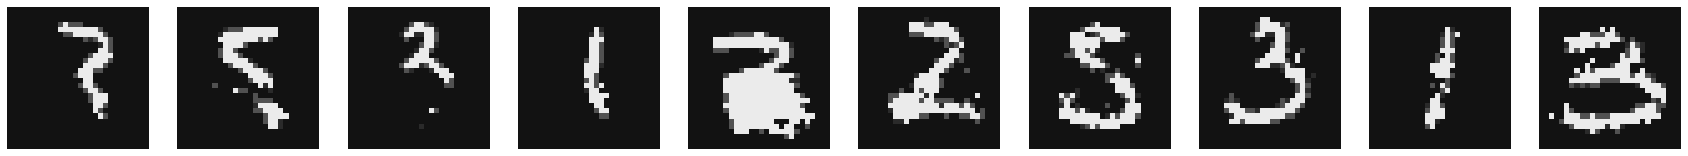

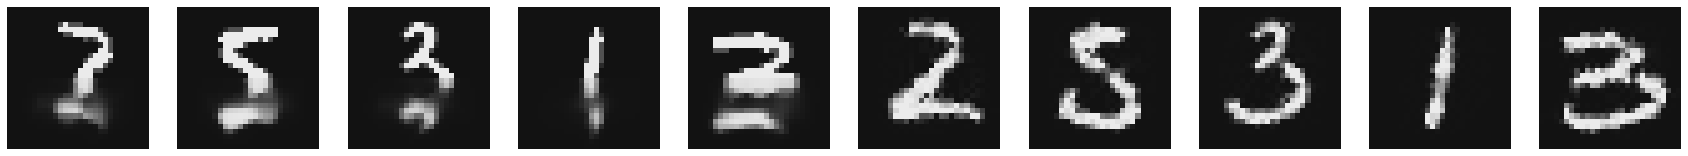

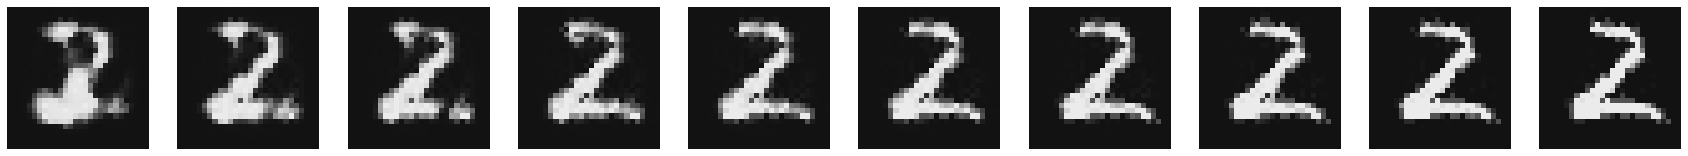

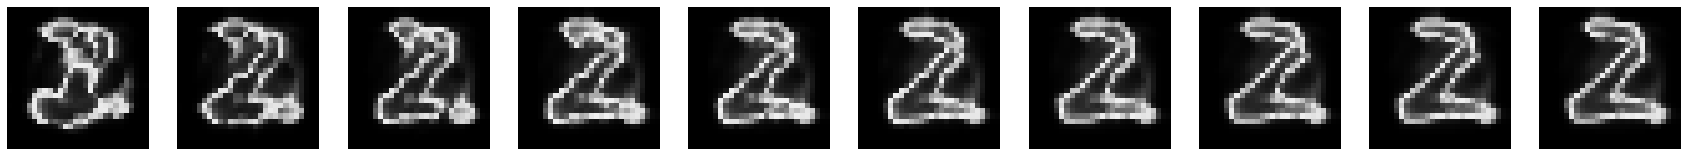

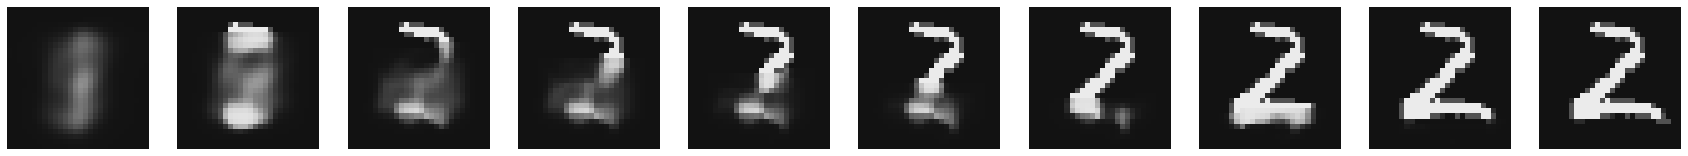

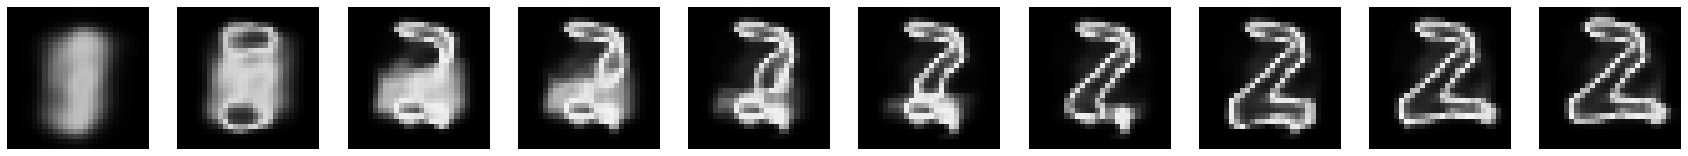

Step 862, Loss (last minibatch): 0.1829543560743332, Loss (80 step avg.): 0.2483769749049787


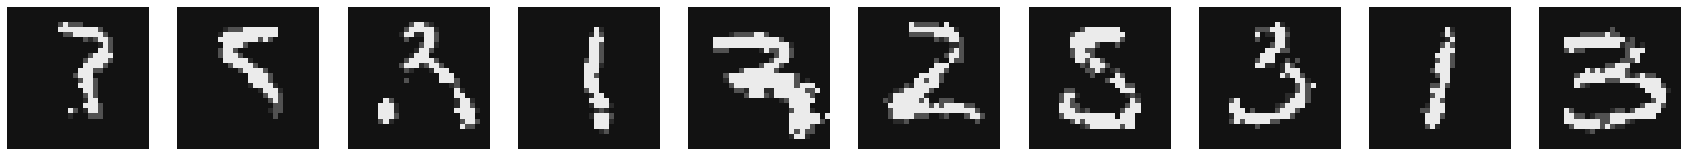

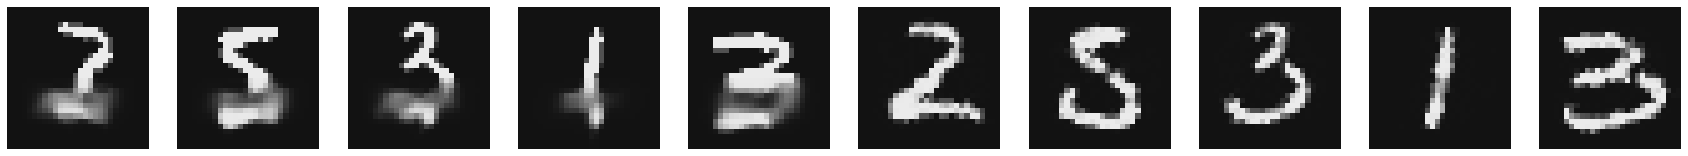

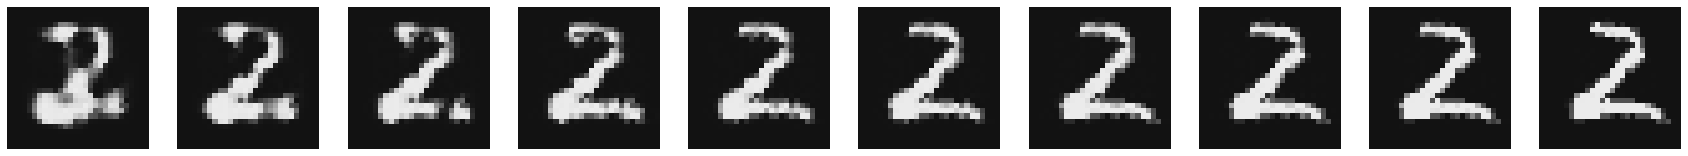

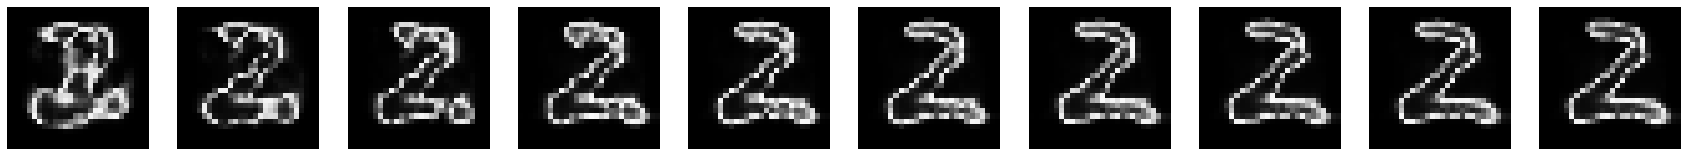

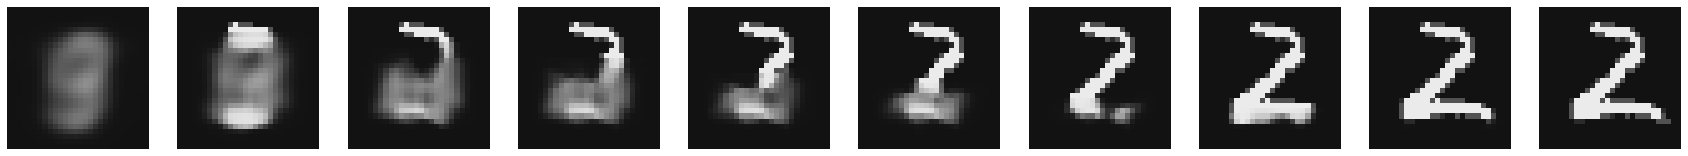

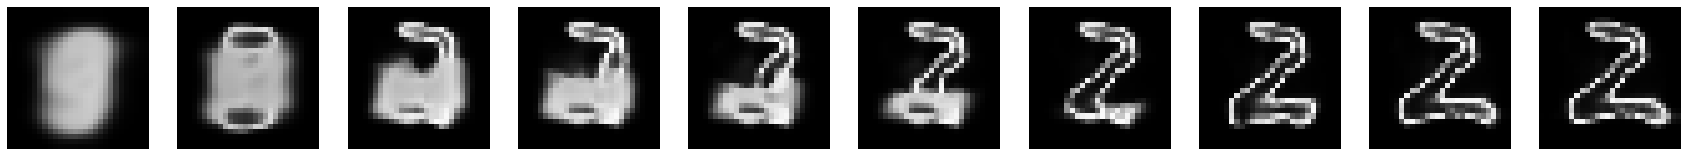

Step 1362, Loss (last minibatch): 0.17792868614196777, Loss (80 step avg.): 0.22968135056672273


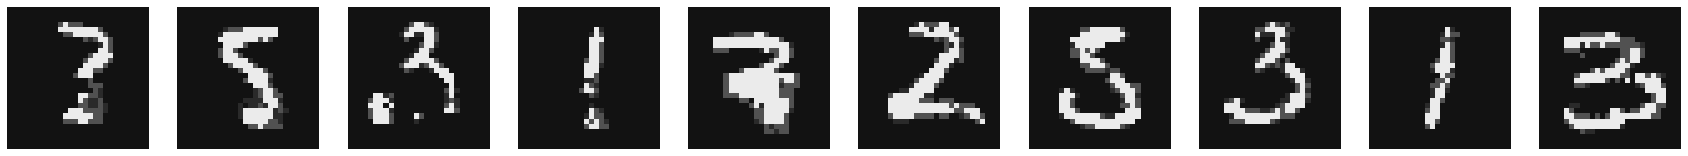

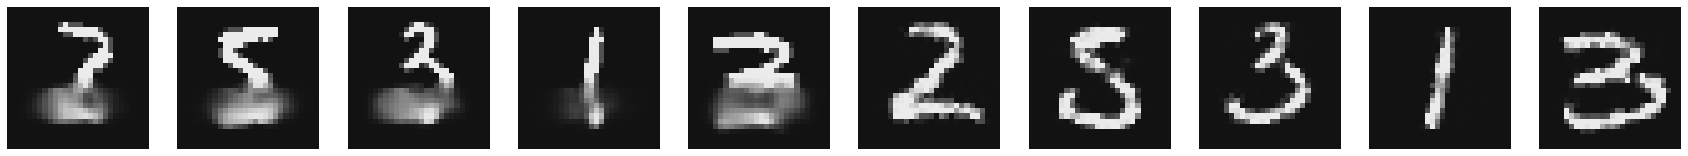

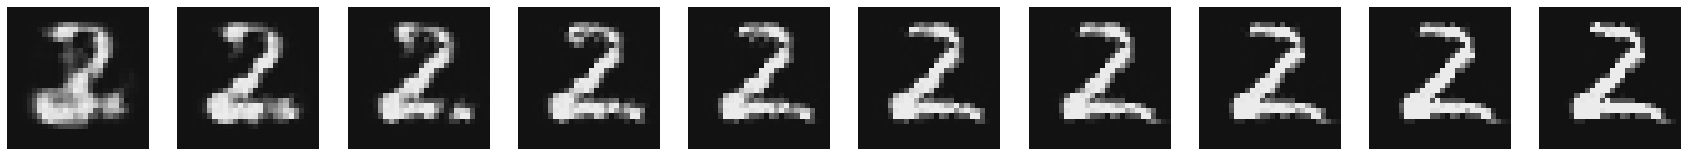

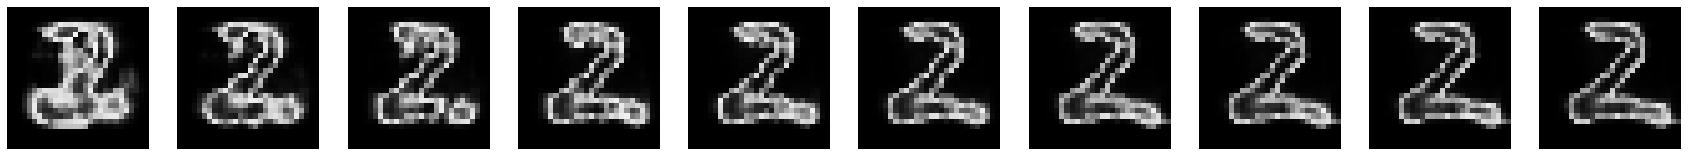

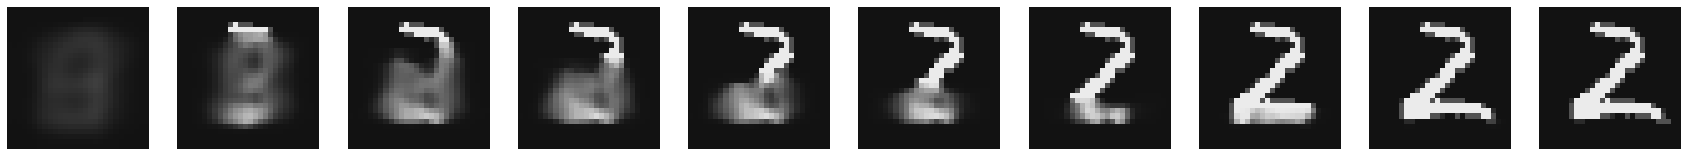

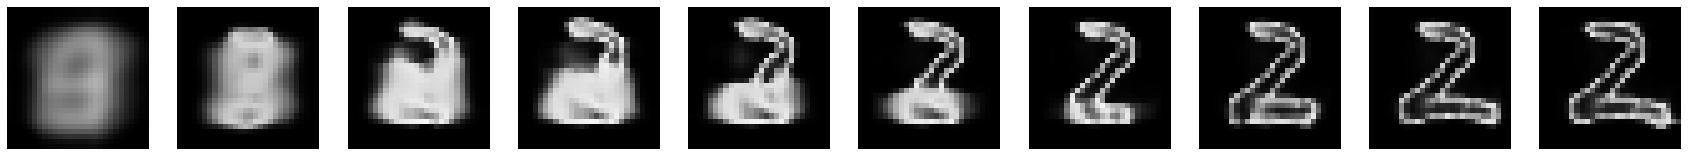

Step 1862, Loss (last minibatch): 0.2295815795660019, Loss (80 step avg.): 0.21759667072767092


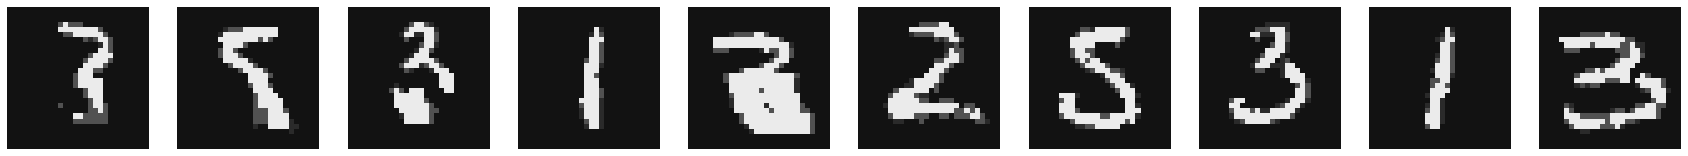

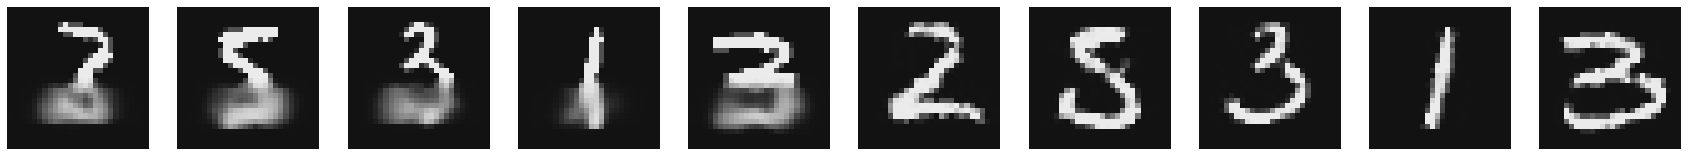

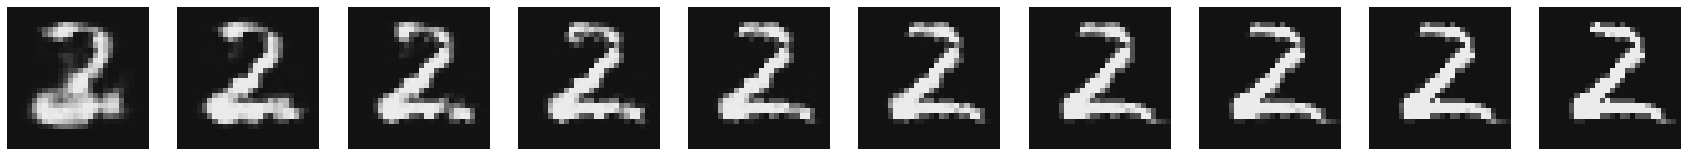

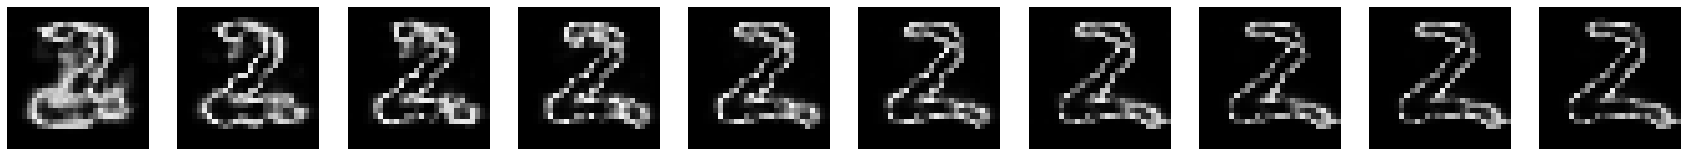

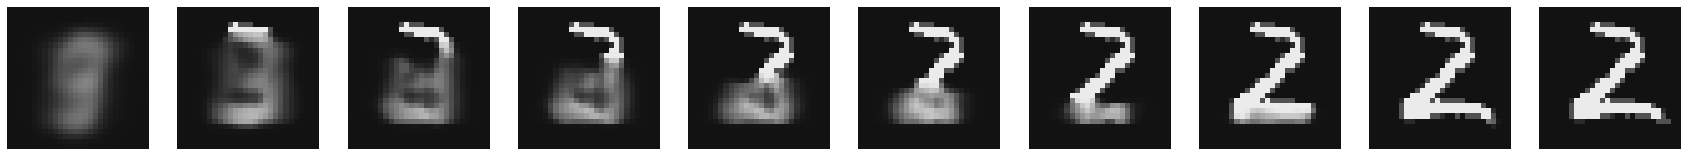

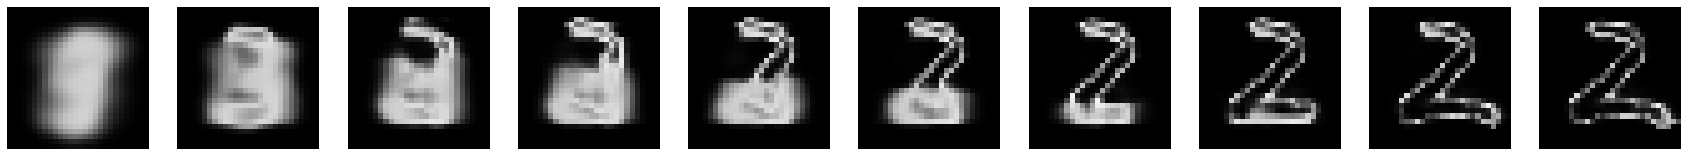

Step 2362, Loss (last minibatch): 0.21244476735591888, Loss (80 step avg.): 0.22053384376160892


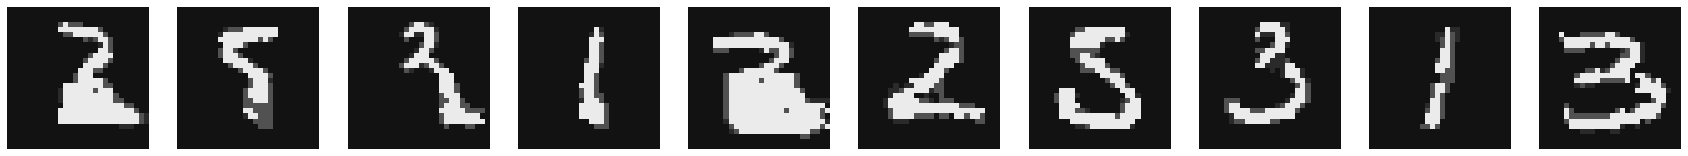

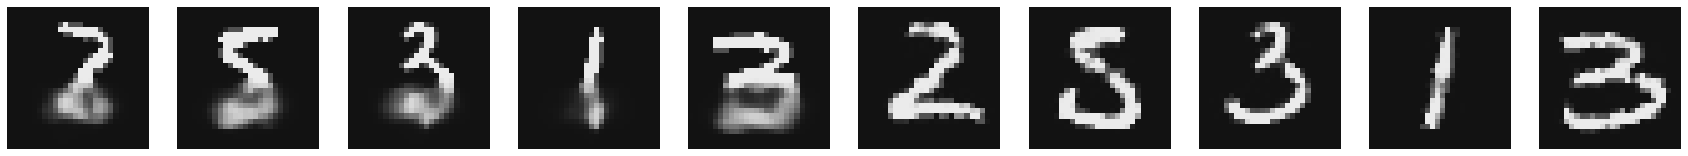

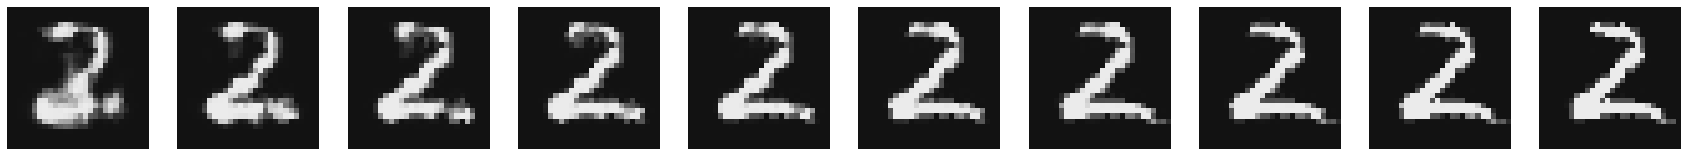

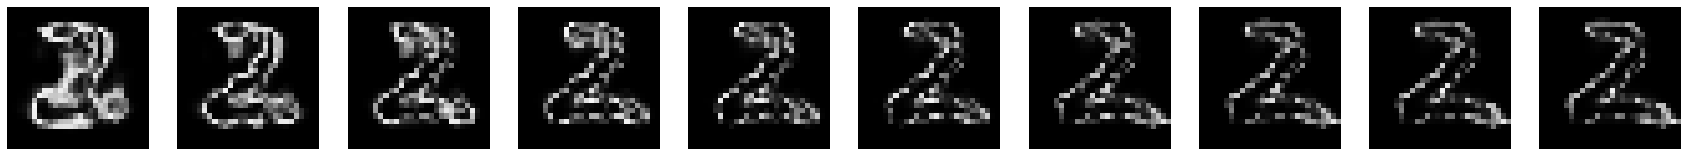

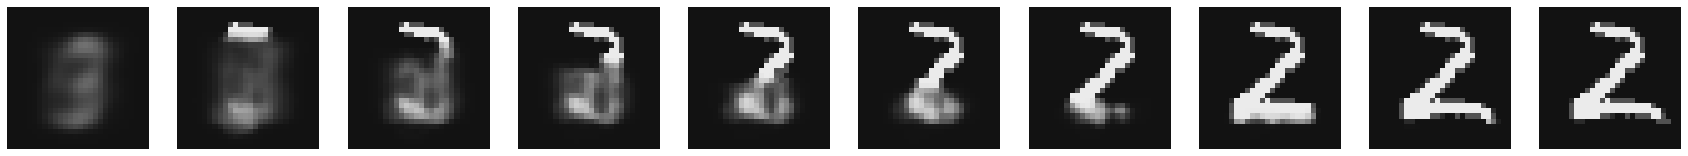

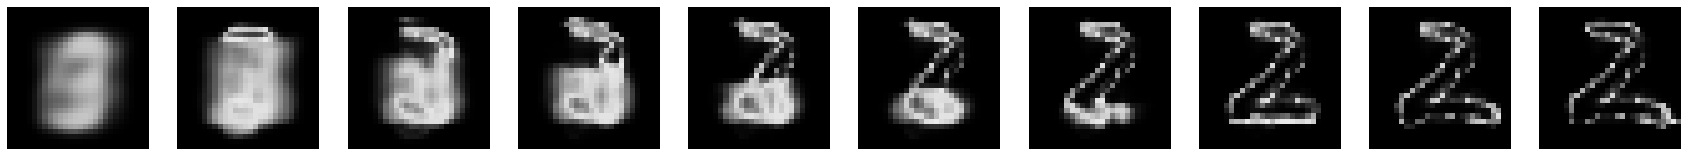

Step 2668, Loss (last minibatch): 0.1437254548072815, Loss (80 step avg.): 0.19790125417488594


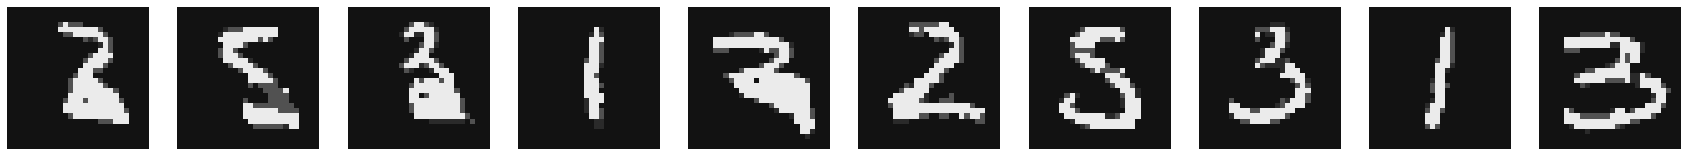

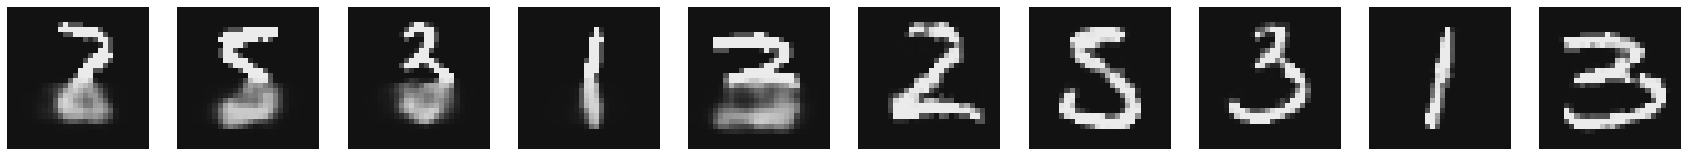

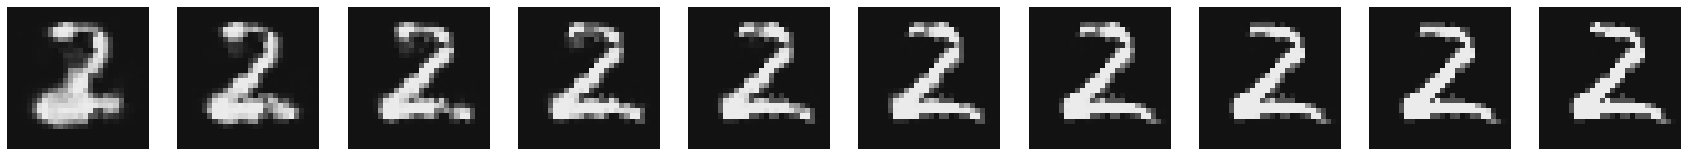

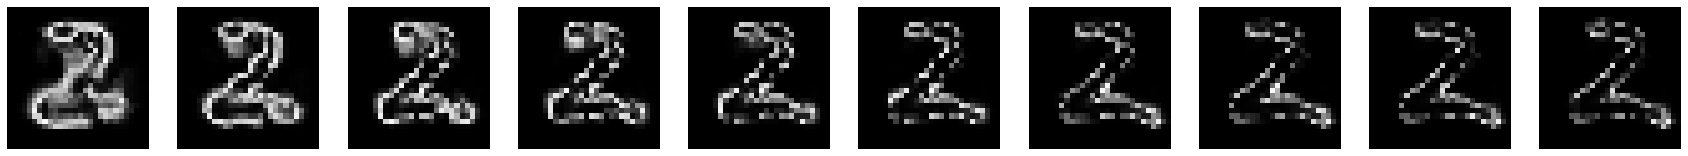

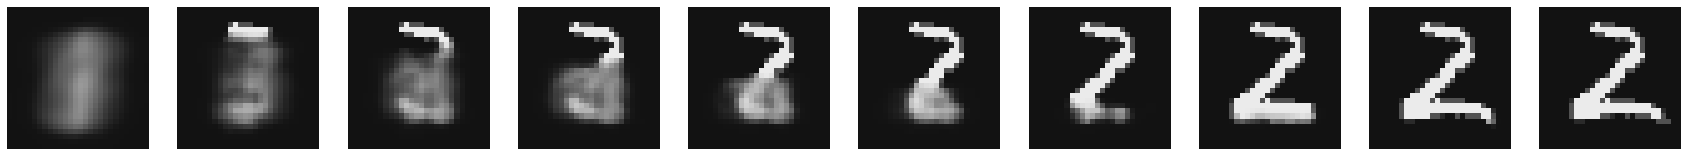

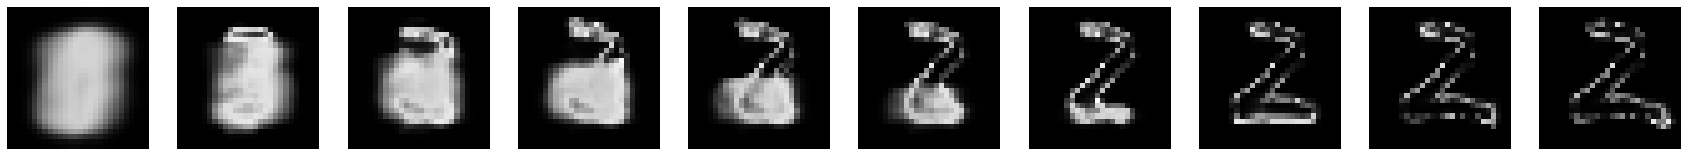

Step 3168, Loss (last minibatch): 0.1568344533443451, Loss (80 step avg.): 0.20089757010156725


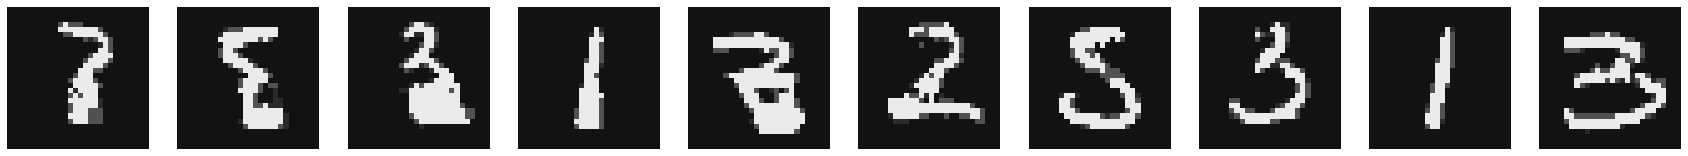

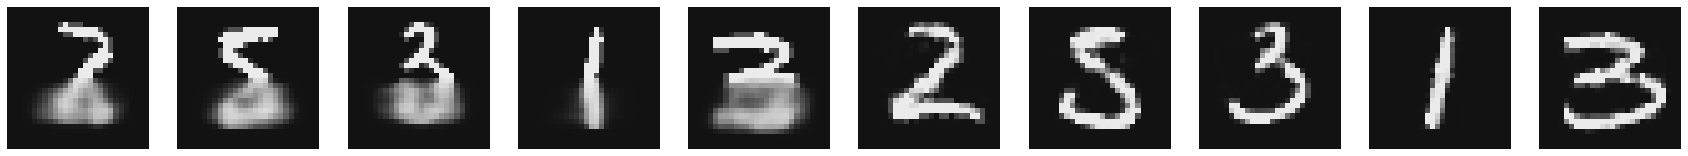

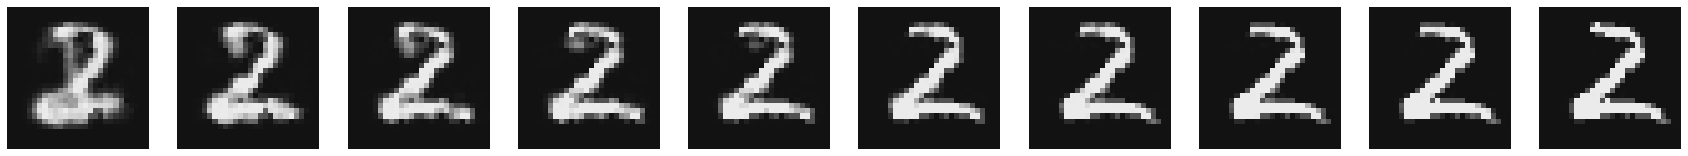

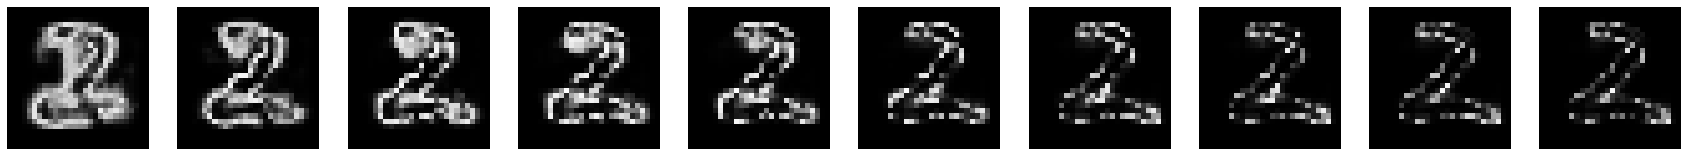

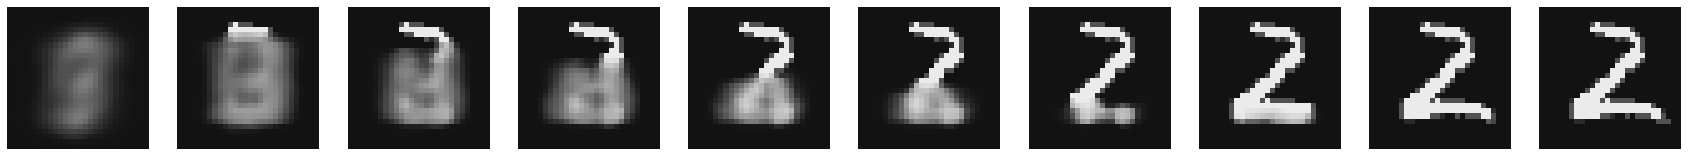

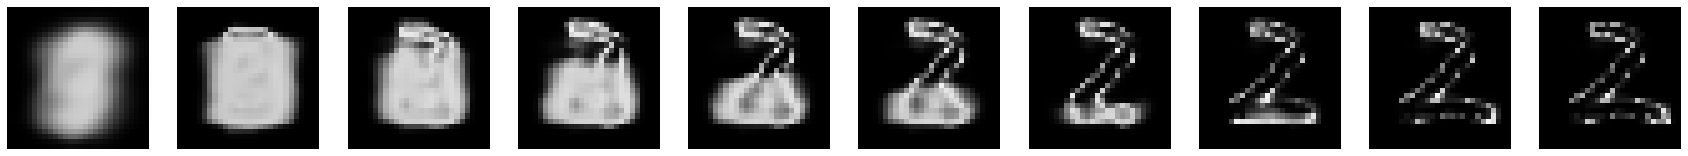

Step 3668, Loss (last minibatch): 0.23034602403640747, Loss (80 step avg.): nan


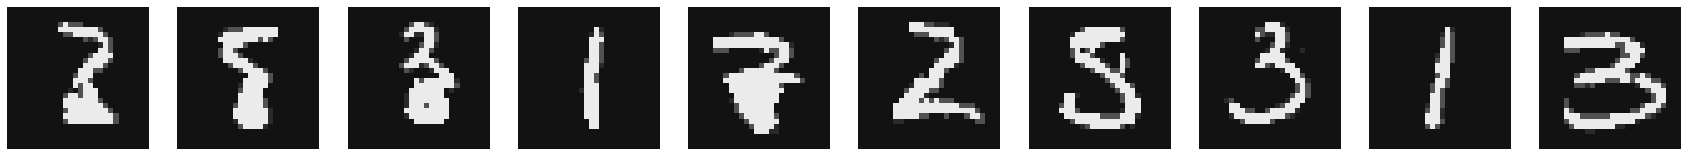

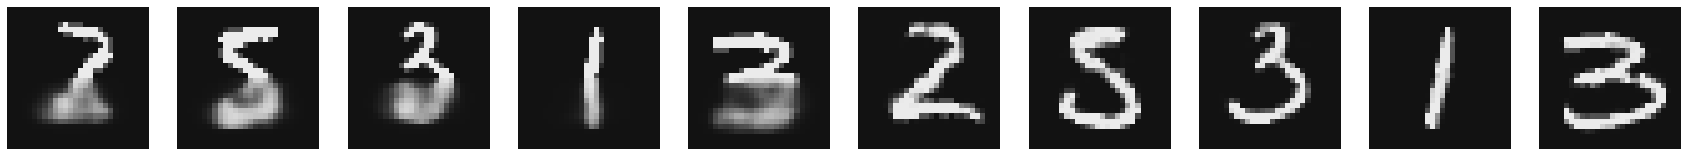

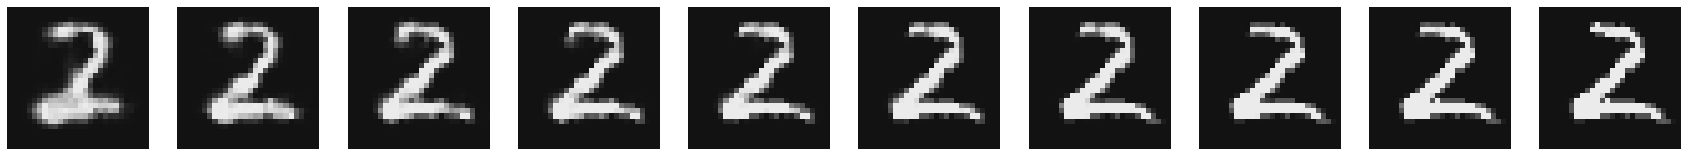

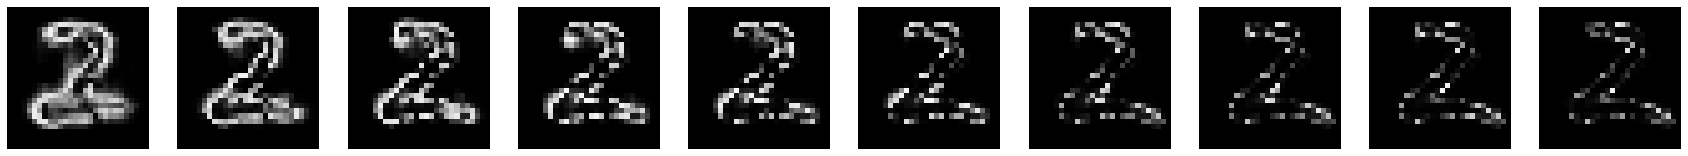

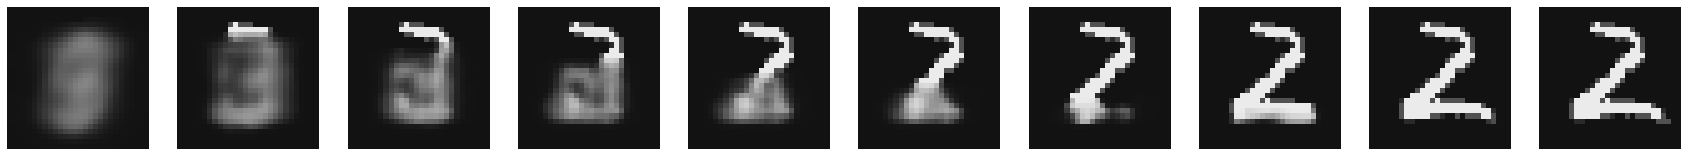

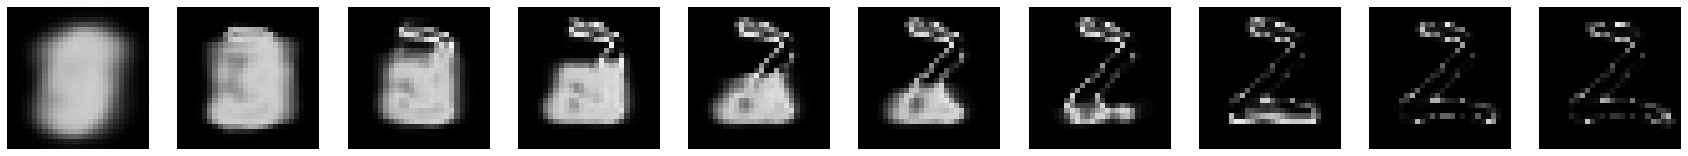

KeyboardInterrupt: 

In [18]:
with strategy.scope():
    training_loop.train()

In [19]:
model_name += "-mixedprecision"
model.save(f"models/{model_name}")

INFO:tensorflow:Assets written to: models/cuda11-28x28-bs3x1x8-mixedprecision/assets


INFO:tensorflow:Assets written to: models/cuda11-28x28-bs3x1x8-mixedprecision/assets


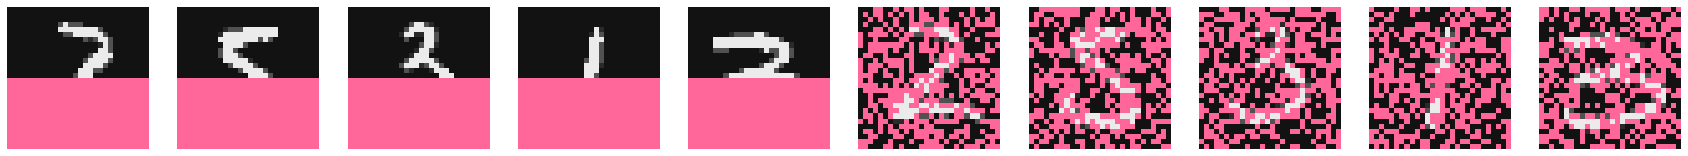

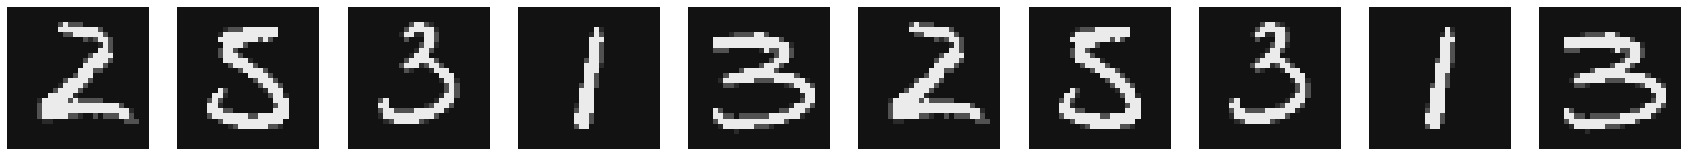

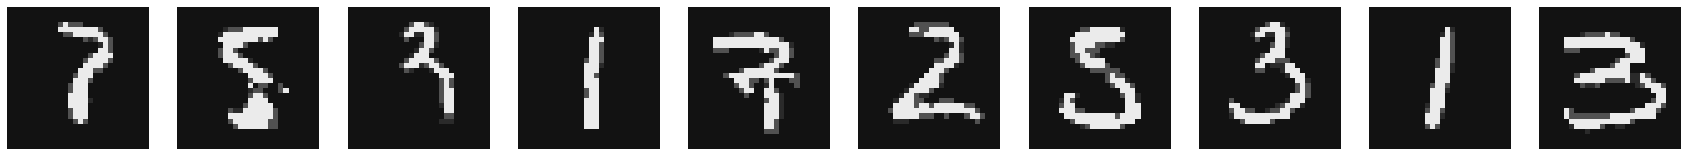

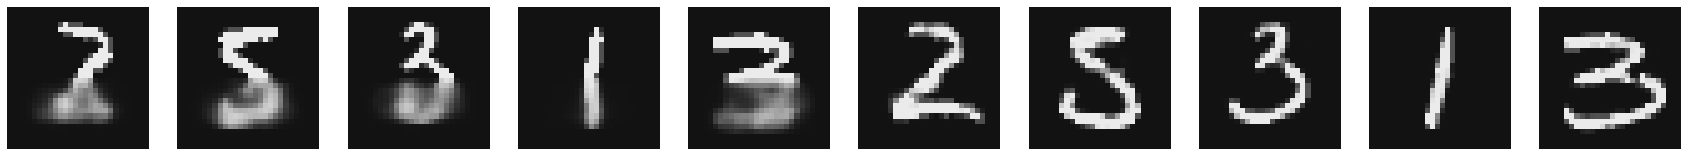

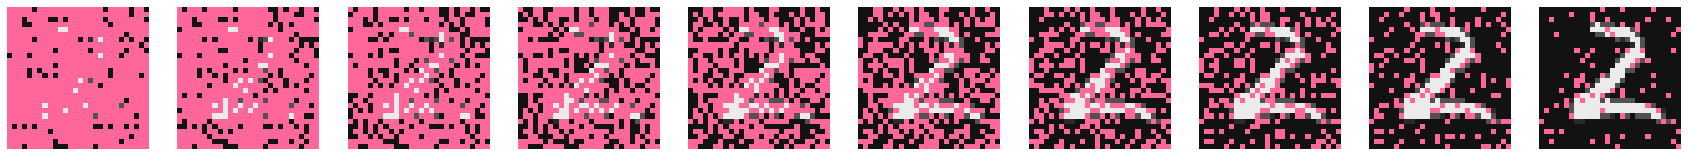

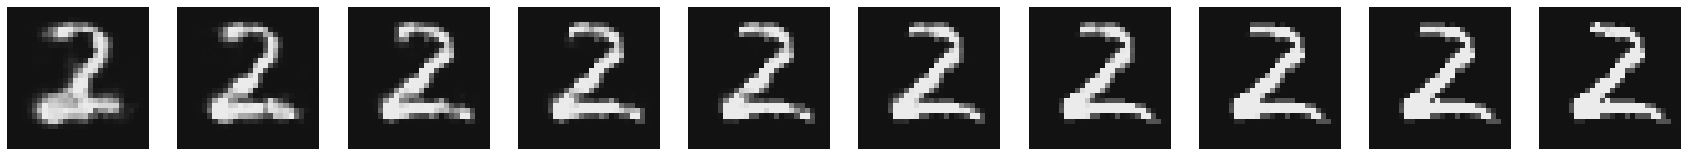

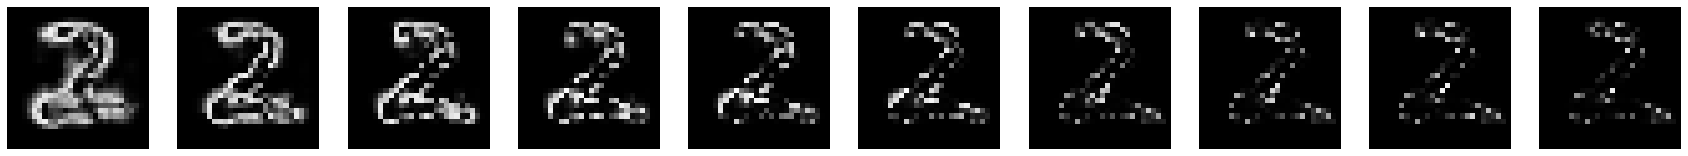

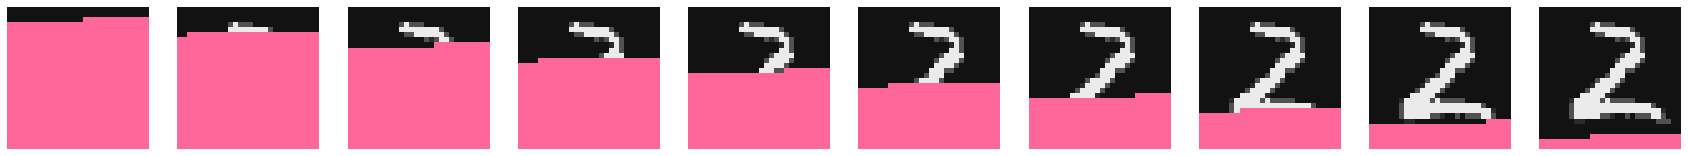

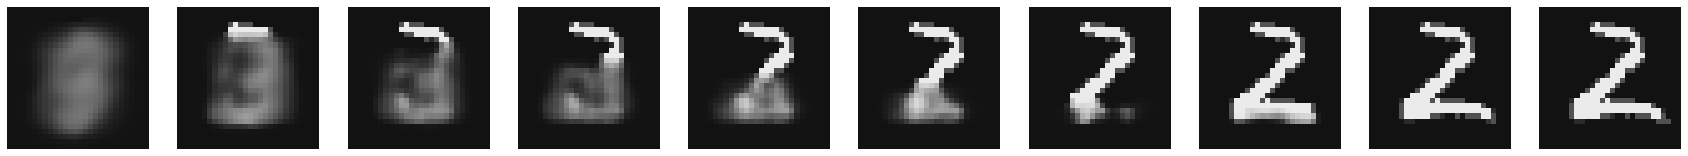

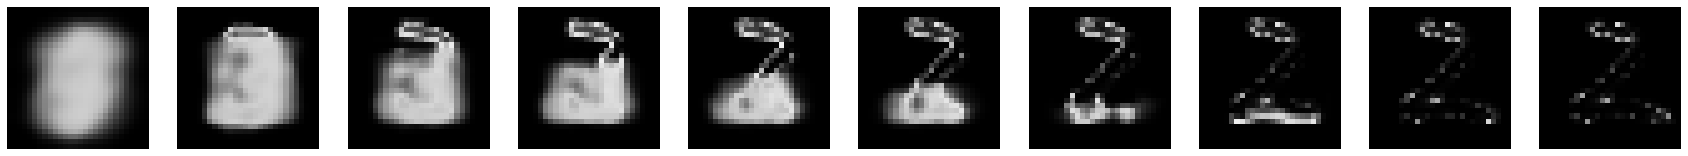

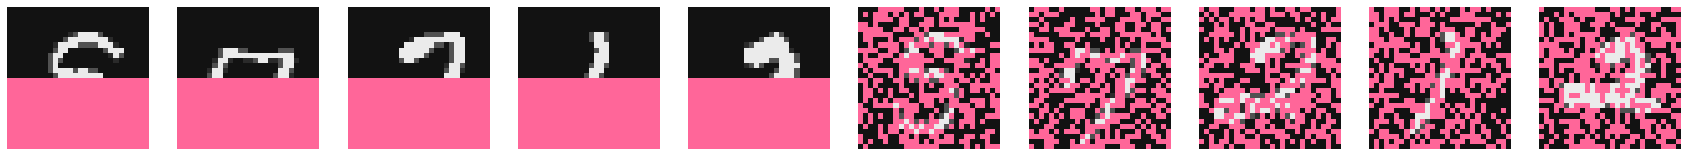

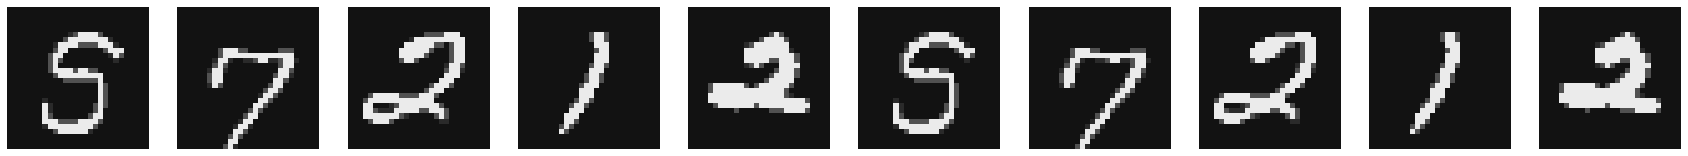

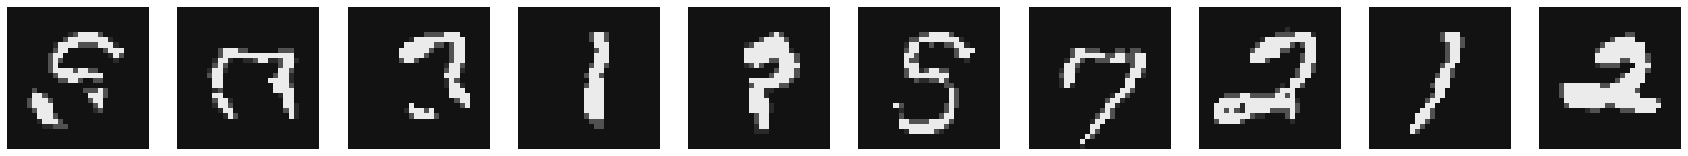

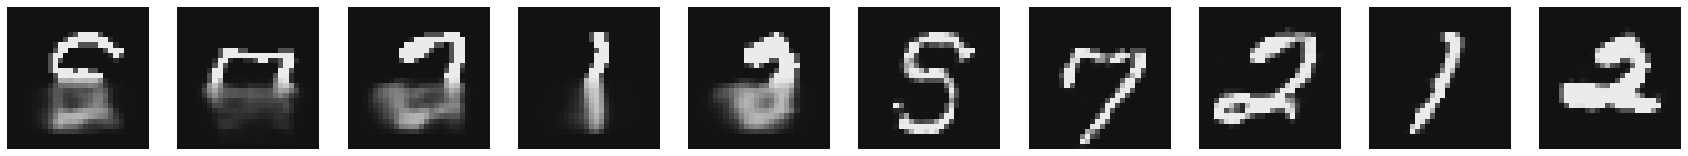

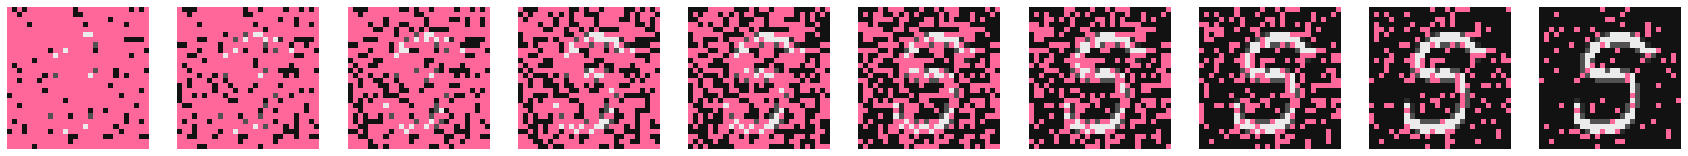

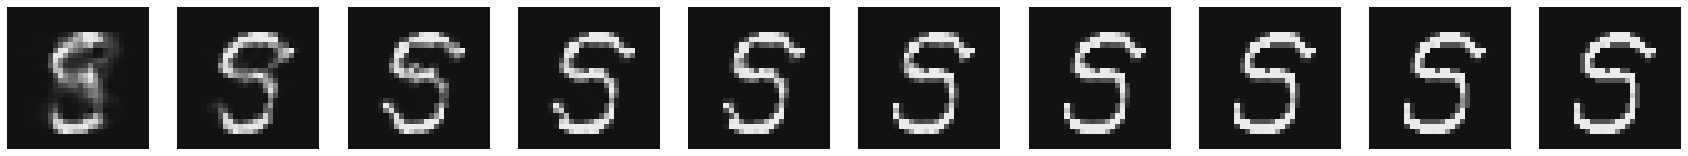

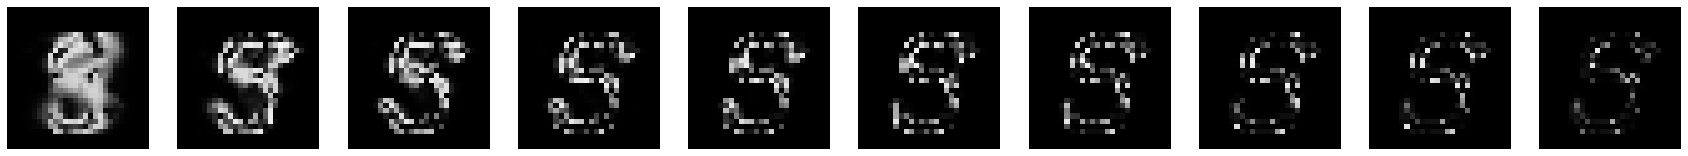

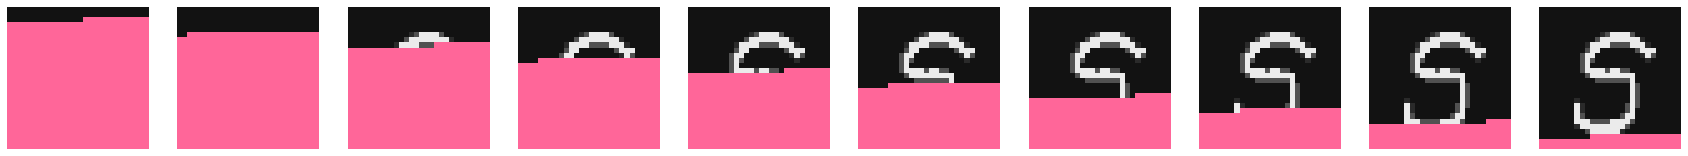

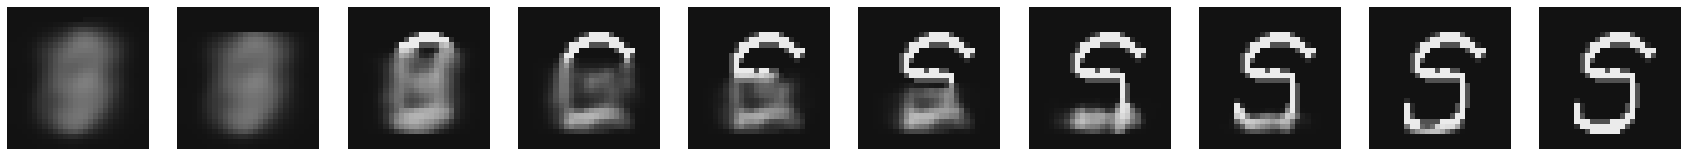

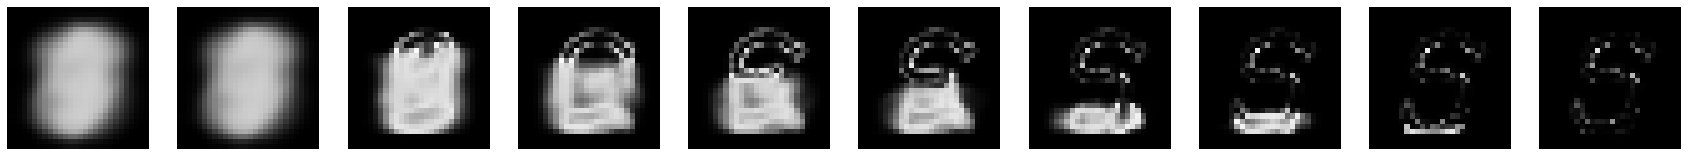

In [20]:
evaler.process_batch(show_input=True)
evaler.new_test_batch()
evaler.process_batch(show_input=True)